Example Notebook for using JNBarcPlot.py
========================================
* Import necessary modules for your analysis.
* Import data and set data paths.
* Make an arc plot with PAIR data.
* Make an arc plot with RInG data. (not yet available)


Importing modules.
------------------
I like to put this at the top of my notebook, all in one place, so that I can see my whole
python environment. The first line, `%matplotlib inline` ensures that plots are rendered
within the notebook. You can use `sys.path.append('path/to/module')` to add modules that are
not normally in your path.

In [1]:
# Set up Python environment

%matplotlib inline
import sys
sys.path.append('/nas/longleaf/home/psirving/JNBTools')
import JNBarcPlot as arc
import plottingTools as pt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Defining data path and reading in data
--------------------------------------
This is where I read in all of my data and set paths to files.

For plottingTools.py functions, a pandas dataframe object is passed.

For JNBarcPlot.py, only the file paths are needed.

In [2]:
path = 'data/'
ctpath = path+'RNaseP.ct'
profilepath = path+'example1_rnasep_profile.txt'
profileobj = pd.read_csv(profilepath, sep='\t') # only needed to set the dimensions of the plot
pairmappath = path+'example-rnasep-pairmap.txt'

Make arc plot with PAIR data
----------------------------
To compare two ct files, use `arc.addCTcompare(ax, ctpath1, ctpath2)` in place of `arc.addCT(ax, ctpath)`.

In the plot below, the ax.set_ylim() parameters are very important.

The sequence bar added during `arc.addProfile()` will appear at the center of the yaxis. It looks best just below the x-axis.
To accomplish this, center the ylims around -2.

To accomodate long range arcs, the ylims should be at least half the length of the longest arc above 0 and below -4.
For example, here, my longest arc is about 264 nt, so I am using (-133-4, 133).

TODO: Create a function to set ylims appropriately.


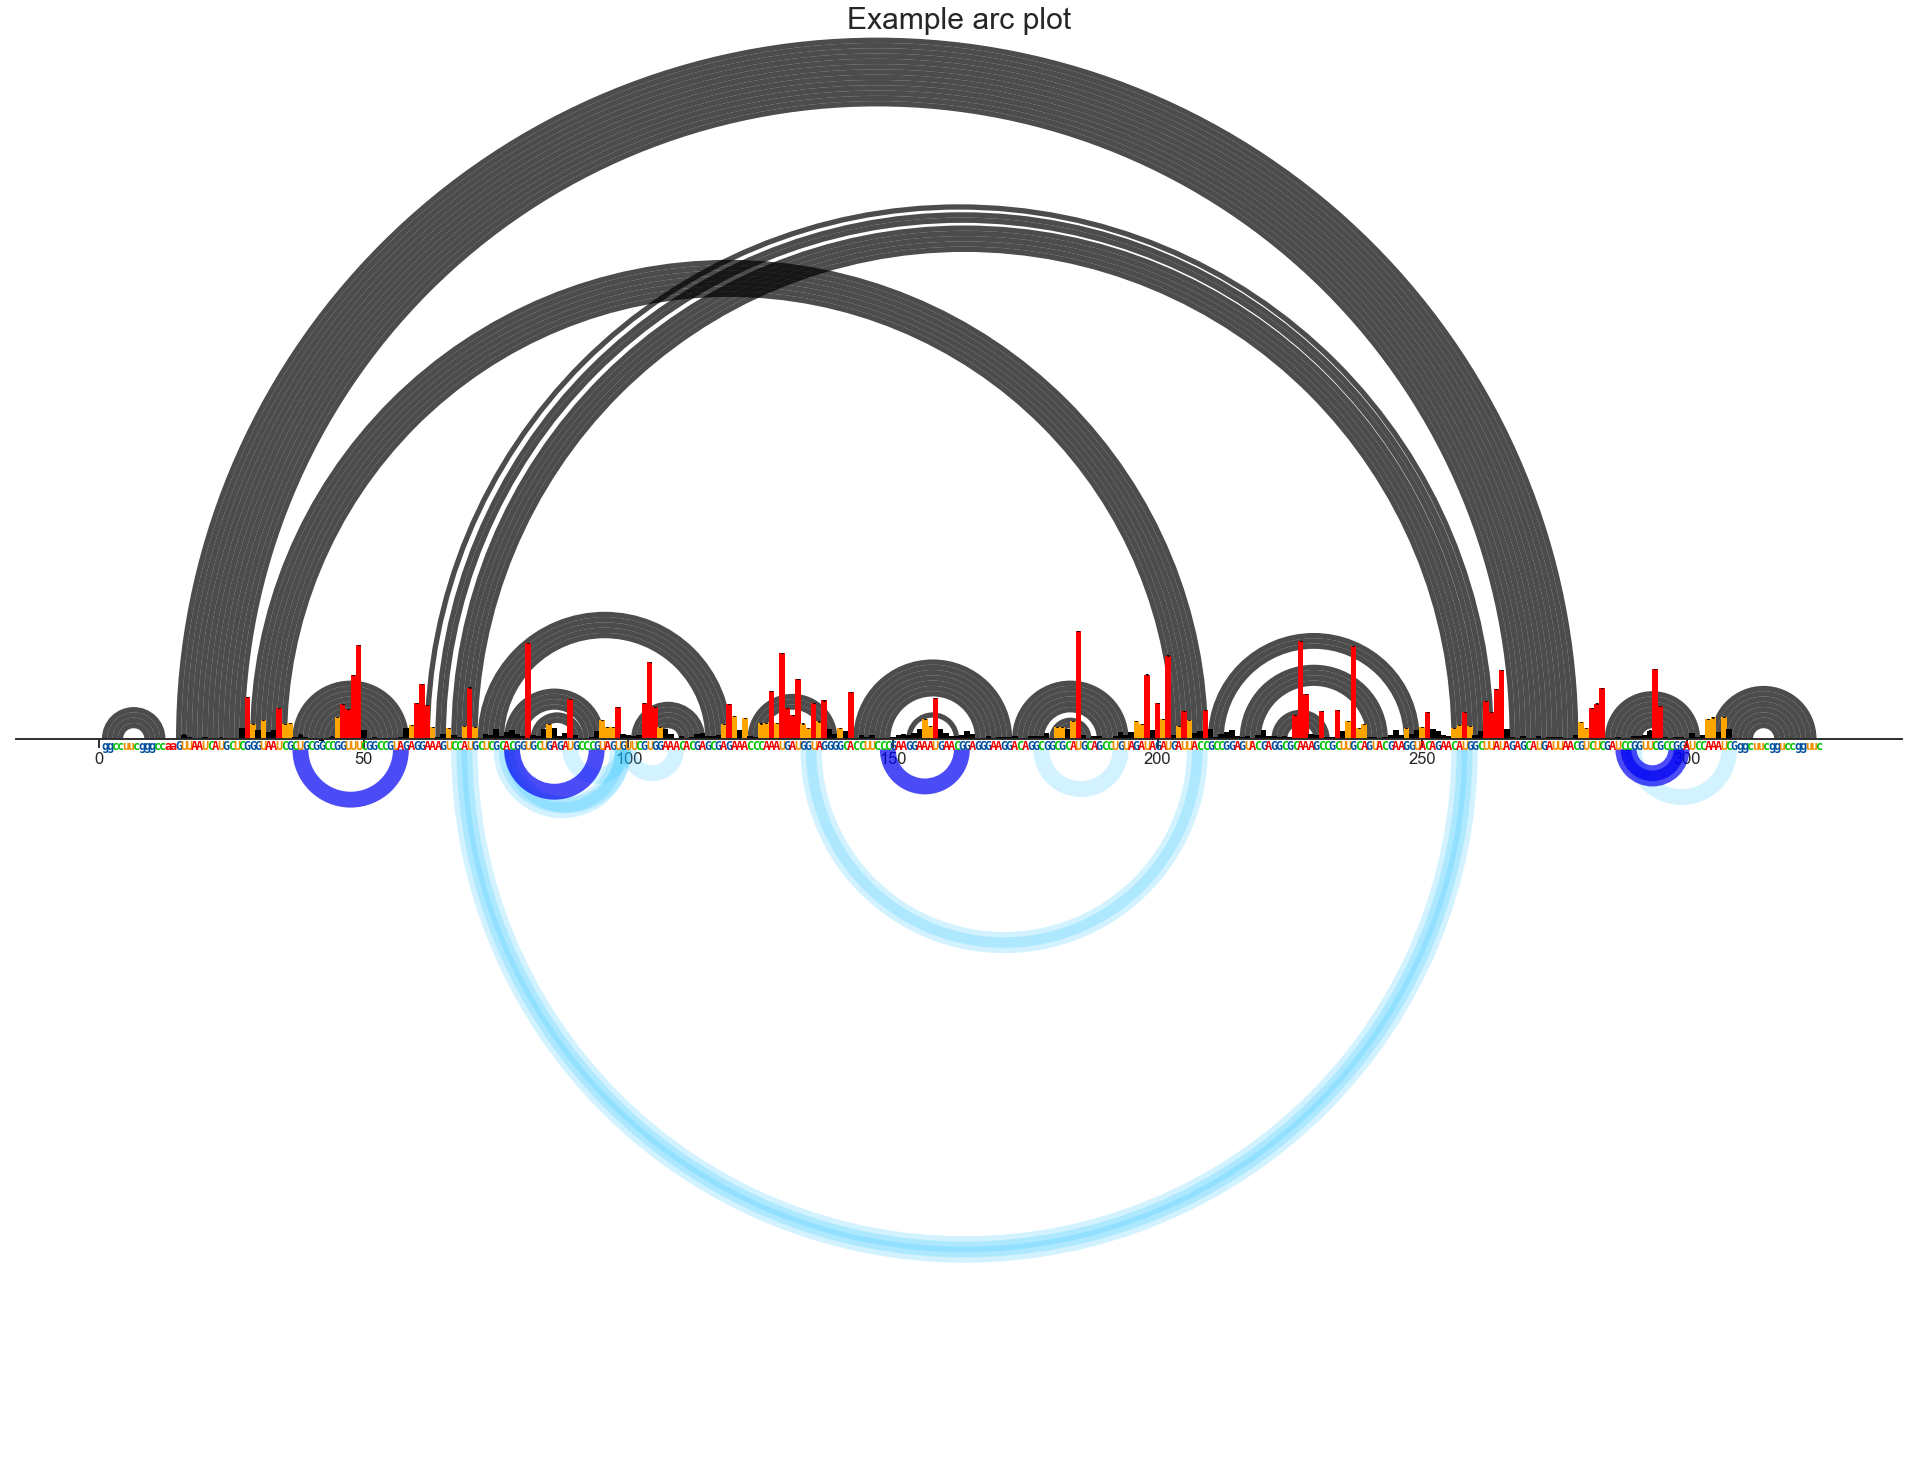

In [3]:
dims = pt.getWidth(profileobj)
fig, ax = plt.subplots(1,1, figsize=(dims, dims))

arc.setArcPlot(ax)
ax.set_ylim(-137,133)
ax.set_title('Example arc plot', fontsize=30)
arc.addCT(ax, ctpath)
arc.addProfile(ax, profilepath)
arc.addPairmap(ax, pairmappath)

Make arc plot with RInG data
----------------------------
This functionality is coming soon. There will be options to add cutoffs based on statistics and contact distance.